In [1]:
import qdmpy
import qdmpy.pl
import qdmpy.plot
import qdmpy.field
import qdmpy.source
import qdmpy.field.bnv

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from collections import defaultdict as dd
import pickle
from tqdm.auto import tqdm

In [2]:
# '%matplotlib widget' allows interactive plots in jupyterlab
# use ''%matplotlib inline' to allow export to pdf
# %matplotlib widget

# [x] renormalise by baseline (largest value)
# [x] go above 1.0 for g
# [x] get fwhm rising again (find a minimum)
# [x] also show curves but on small region of flake
# [ ] also try a different dataset nearer centre of laser
# [x] test with polygon background subtraction

# GPU NOW SAMUEL
# [ ] test with lower binning (needs new polygons, zpn_region, FLAKE) -> maybe test with gpu {add tqdm globally, use for both}

### Load raw data

In [3]:
RUN_FITS = True
# FLAKE = (140, 100)
FLAKE = (164, 150)
NUM_G = 20
options_dict = {
    "base_dir": "/home/samsc/ResearchData/test_images/global_pl_test/",
    "filepath": "ODMR - Pulsed_140",
    "custom_output_dir_suffix": "_{ROI}_bin_{total_bin}",
    
    "additional_bins": 4,
    
    "single_pixel_check": FLAKE,
    
    "exp_reference_type": "field",
    "plot_bnv_flip_with_bias_mag": False,
    "annotate_polygons": True,
    "standoff": 100e-9,
    "zero_point_normalisation_region": [[45,125], [70, 155]],
    "fourier_pad_mode": "mean",
    "fourier_do_hanning_filter": False,
    
#     "polygon_nodes_path": "/home/samsc/ResearchData/test_images/global_pl_test/polys8.json",
    
    "system_name": "Cryo_Widefield",

    "ROI": "Full", 
    "ROI_start": [37, 37],
    "ROI_end": [113, 167],
#     "ROI_start": [150, 150],
#     "ROI_end": [450,500],
    
    "fit_backend": "scipyfit",
    "fit_backend_comparison": ["scipyfit"],
    "fit_pixels": True, 
    "force_fit": False, 

    "use_ROI_avg_fit_res_for_all_pixels": True,    
    "scipyfit_sub_threads": 2, 

    "fit_functions":  {"linear": 1, "lorentzian": 2},

    "pos_guess": [2730, 3020],
    "pos_range": 25,

    "amp_guess": -0.015,
    "amp_bounds": [-0.300, -0.00003],
    
    "fwhm_bounds": [3, 20],
    
    "save_fig_type": "pdf",
    
    "freqs_to_use": [1, 0, 0, 0, 0, 0, 0, 1],
    "diamond_ori": "<100>_<100>", # HPHT
    
    "auto_read_bias": True,
    
    "colormap_range_dicts": {
        "bnv_images": {
            "type": "mean_plus_minus",
            "values": 2
        },
        "bfield_images": {
            "type": "percentile",
            "values": [2, 98]
        },
        "magnetization_images": {
            "type": "strict_range",
            "values": [-100, 100]
        },
        "residual_images": {
            "type": "strict_range",
            "values": [0, 0.05]
        },
        "sigma_images": {
            "type": "percentile",
            "values": [2, 98]
        },
        "param_images": {
            "type": "percentile",
            "values": [2, 98]
        },
        "dshift_images": {
            "type": "percentile",
            "values": [2, 98]
        },
    },
    
    "recon_methods": ["from_bnv"]
}

In [4]:
options, ref_options = qdmpy.initialize(
    options_dict=options_dict,
    ref_options_dir=None,
    set_mpl_rcparams=True
)

/home/samsc/.local/lib/python3.8/site-packages/qdmpy/interface.py:525: UserWarning: Option fit_pixels was not recognised by the Cryo Widefield system.
  warnings.warn(f"Option {key} was not recognised by the {system.name} system.")
/home/samsc/.local/lib/python3.8/site-packages/qdmpy/interface.py:226: UserWarning: Continuing without reference. (No reference chosen or exp_referece_type was 'None')
  warnings.warn(


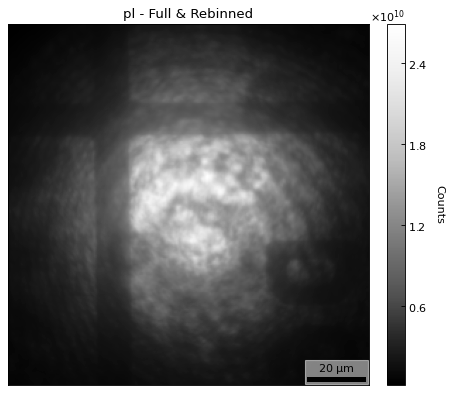

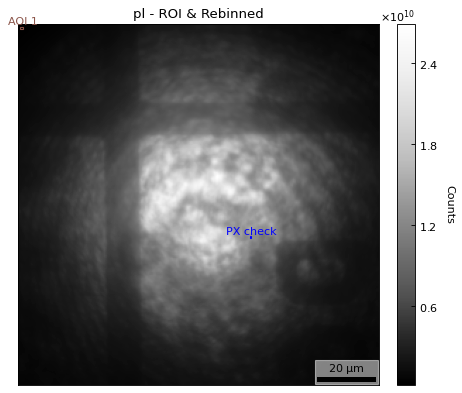

In [5]:
image, prelim_sweep_list = qdmpy.pl.load_image_and_sweep(options)
PL_image, PL_image_ROI, sig, ref, full_sig_norm, single_pixel_pl, sweep_list, ROI = qdmpy.pl.reshape_dataset(
        options, image, prelim_sweep_list
    )

ROI_PL_fig = qdmpy.plot.roi_pl_image(options, PL_image)
AOI_PL_fig = qdmpy.plot.aoi_pl_image(options, PL_image)
qdmpy.pl.save_pl_data(options, PL_image, PL_image_ROI)

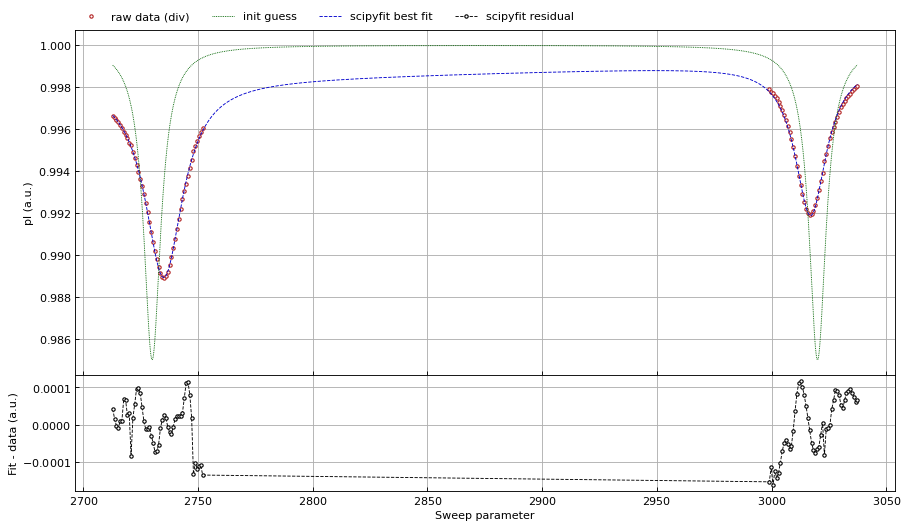

In [6]:
fit_model = qdmpy.pl.define_fit_model(options)
backend_ROI_results_lst = qdmpy.pl.fit_roi_avg_pl(options, full_sig_norm, sweep_list, fit_model)
ROI_fit_fig = qdmpy.plot.roi_avg_fits(options, backend_ROI_results_lst)
wanted_roi_result = next(
    filter(
        lambda result: result.fit_backend == options["fit_backend"], backend_ROI_results_lst
    )
) # ROI fit result for chosen fit backend
roi_avg_vec = wanted_roi_result.pl_roi

# subtract g * roi_fit from every pixel in sig_norm.
# wanted_roi_result.best_params[0], wanted_roi_result.best_params[1] = 0, 0
# roi_fit_vec = wanted_roi_result.fit_model(wanted_roi_result.best_params, wanted_roi_result.sweep_list)

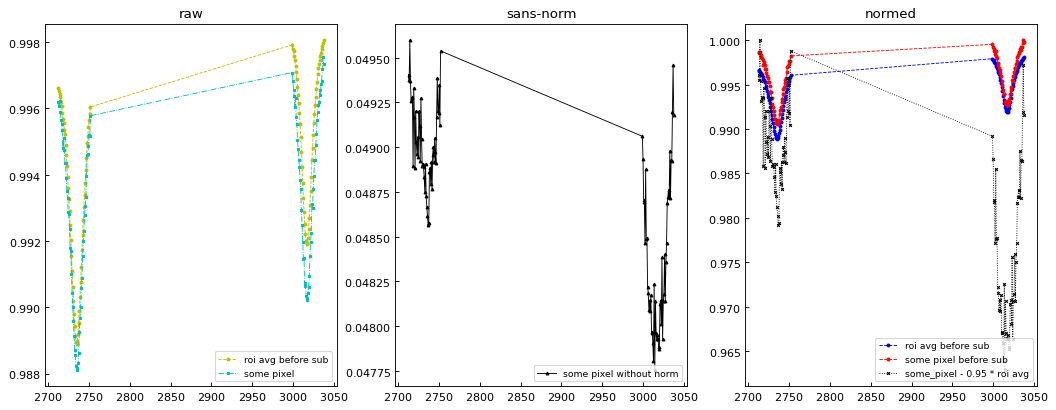

In [7]:
test_g = 0.95
slicer = np.s_[:, 50, 50]

# test subtraction
full_sig_norm.shape
full_sig_norm[:, 0, 0]
a = np.linspace(1, 99, 99)
sub_avg = full_sig_norm - test_g * roi_avg_vec[:, None, None]

# x = np.mean(np.mean(x_full, axis=2), axis=1)
# argmax = np.argmax(np.abs(x), axis=0)
# x /= x[argmax]

# y = np.mean(np.mean(full_sig_norm, axis=2), axis=1)
# argmax = np.argmax(np.abs(y), axis=0)
# y /= y[argmax]
argmax = np.expand_dims(np.argmax(np.abs(sub_avg), axis=0), axis=0)
sub_avg_norm = sub_avg / np.take_along_axis(sub_avg, argmax, axis=0)

argmax = np.expand_dims(np.argmax(np.abs(full_sig_norm), axis=0), axis=0)
without_sub_norm = full_sig_norm / np.take_along_axis(full_sig_norm, argmax, axis=0)

tf, tas = plt.subplots(ncols=3, figsize=(16, 6))
tas[0].set_title("raw")
tas[0].plot(sweep_list, roi_avg_vec, "o--y", ms=2.5, label="roi avg before sub")
# tas[0].plot(sweep_list, np.mean(np.mean(sub_avg_norm,axis=2), axis=1), "s-.m", ms=2.5, label="roi avg with sub")
tas[0].plot(sweep_list, full_sig_norm[slicer], "s-.c", ms=2.5, label="some pixel")
tas[0].legend(loc="lower right")
# tas[0].plot(sweep_list, full_sig_norm[:, 50, 50] - 0.8 * roi_avg_vec, "x-k", ms=2.5, label=f"some_pixel - {test_g} * roi avg")

tas[1].set_title("sans-norm")
tas[1].plot(sweep_list, sub_avg[slicer], "^-k", ms=2.5, label="some pixel without norm")
tas[1].legend(loc="lower right")

tas[2].set_title("normed")
tas[2].plot(sweep_list, roi_avg_vec, "o--b", ms=2.5, label="roi avg before sub")
tas[2].plot(sweep_list, without_sub_norm[slicer], "o--r", ms=2.5, label="some pixel before sub")
tas[2].plot(sweep_list, sub_avg_norm[slicer], "x:k", ms=2.5, label=f"some_pixel - {test_g} * roi avg")
tas[2].legend(loc="lower right")

# fit_model.get_param_defn()
# wanted_roi_result.best_params
None

In [8]:
if RUN_FITS:
    fwhm_lst = []
    bnv_lst = []
    resids_lst = []
    avg_spectra = []
    g_vec = np.concatenate((np.linspace(start=0, stop=0.95, num=NUM_G//2), np.linspace(start=1.05, stop=2, num=NUM_G//2)))
    for g in tqdm(g_vec):
        sig_norm = full_sig_norm - g * roi_avg_vec[:, None, None]
#         argmax = np.argmax(np.abs(sig_norm), axis=0)
#         np.divide(sig_norm, sig_norm[argmax])
#         sig_norm /= sig_norm[argmax] 
        
        # renormalise to [0-1]
        argmax = np.expand_dims(np.argmax(np.abs(sig_norm), axis=0), axis=0)
        sig_norm = sig_norm / np.take_along_axis(sig_norm, argmax, axis=0)

        roi_results = qdmpy.pl.fit_roi_avg_pl(options, sig_norm, sweep_list, fit_model)
        new_roi_avg = next(
                filter(
                    lambda result: result.fit_backend == options["fit_backend"], roi_results
            )
        )
        avg_spectra.append(new_roi_avg.pl_roi)

        pixel_fit_params, sigmas = qdmpy.pl.get_pl_fit_result(options, sig_norm, sweep_list, fit_model, new_roi_avg)

        bnvs, _ = qdmpy.field.bnv.get_bnvs_and_dshifts(pixel_fit_params, options["bias_field_spherical_deg_gauss"])

        fwhm_lst.append([pixel_fit_params["fwhm_0"], pixel_fit_params["fwhm_1"]])
        bnv_lst.append(bnvs[0])

        resids_lst.append(pixel_fit_params["residual_0"])
        
    with open(options["base_dir"] + f"results_{options['additional_bins']}.pickle", 'wb') as f:
        g = g_vec if isinstance(g_vec, list) else g_vec.tolist()
        pickle.dump([g, avg_spectra, fwhm_lst, bnv_lst, resids_lst], f, pickle.HIGHEST_PROTOCOL)
else:
    with open(options["base_dir"] +  f"results_{options['additional_bins']}.pickle", 'rb') as f:
        [g_vec, avg_spectra, fwhm_lst, bnv_lst, resids_lst] = pickle.load(f)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/65536 [00:00<?, ? PX/s]

  0%|          | 0/65536 [00:00<?, ? PX/s]

  0%|          | 0/65536 [00:00<?, ? PX/s]

  0%|          | 0/65536 [00:00<?, ? PX/s]

  0%|          | 0/65536 [00:00<?, ? PX/s]

  0%|          | 0/65536 [00:00<?, ? PX/s]

  0%|          | 0/65536 [00:00<?, ? PX/s]

  0%|          | 0/65536 [00:00<?, ? PX/s]

  0%|          | 0/65536 [00:00<?, ? PX/s]

  0%|          | 0/65536 [00:00<?, ? PX/s]

KeyboardInterrupt: 

In [ ]:
bnv_sub_bground_lst = []
mz_lst = []
for g_idx, g in enumerate(g_vec):
    bnvs = [bnv_lst[g_idx]]
    pts = [(16, 27), (9, 21), (59, 23)]
#     bnvs_sub_bground = qdmpy.field.bnv.sub_bground_bnvs(options, bnvs, "interpolate", interp_method="linear", sigma=3)
    bnvs_sub_bground = qdmpy.field.bnv.sub_bground_bnvs(options, bnvs, "poly", order=3)
    bnv_sub_bground_lst.append(bnvs_sub_bground[0])
   
    source_params = qdmpy.source.odmr_source_retrieval(options, bnvs_sub_bground, None)
    mz_lst.append(source_params["Mz_from_bnv"])

In [ ]:
nrows = len(g_vec)
ncols = options["fit_functions"]["lorentzian"] + 2
fsize = matplotlib.rcParams["figure.figsize"].copy()
fsize[0] *= ncols * 0.85
fsize[1] *= nrows
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, constrained_layout=True, figsize=fsize)

fwhm_c_map = "viridis"
fwhm_c_range_dict = {"type": "strict_range", "values": [0,25]}

bnv_c_map = "bwr"
bnv_c_range_dict = {"type": "mean_plus_minus", "values": 2}

sigma_c_map = "magma"
sigma_c_range_dict = {"type": "strict_range", "values": [0, 0.05]}

delta_fwhm_c_map = "jet"
delta_fwhm_c_range_dict = {"type": "strict_range", "values": [-15, 15]}

mz_c_map = "PuOr"
mz_c_range_dict = {"type": "strict_range","values": [-100, 100]}

for g_idx, g_value in enumerate(g_vec):
    
    axs[g_idx, 0].plot(
        sweep_list,
        avg_spectra[g_idx],
        label=f"new spectrum",
        ls=" ",
        marker="o",
        mfc="w",
        mec="firebrick",
    )
    
    for fwhm_idx in range(2):
        fwhm_image = fwhm_lst[g_idx][fwhm_idx] 
        fwhm_c_range = qdmpy.plot.get_colormap_range(fwhm_c_range_dict, fwhm_image)
        qdmpy.plot.plot_image_on_ax(fig, axs[g_idx, fwhm_idx+1], options, fwhm_image, f"g = {g_value}, fwhm_{fwhm_idx}", fwhm_c_map, fwhm_c_range, "FWHM (MHz)")
    
    # plot delta fwhm from g = 0
    delta_fwhm_image = fwhm_lst[g_idx][0] + fwhm_lst[g_idx][1] - fwhm_lst[0][0] - fwhm_lst[0][1]
    delta_fwhm_range = qdmpy.plot.get_colormap_range(delta_fwhm_c_range_dict, delta_fwhm_image)
    qdmpy.plot.plot_image_on_ax(fig, axs[g_idx, 3], options, delta_fwhm_image, f"g = {g_value},  " + r"$\Delta fwhm$", delta_fwhm_c_map, delta_fwhm_range, "(2*) FWHM (MHz)")    

    
nrows = len(g_vec)
ncols = 4
fsize = matplotlib.rcParams["figure.figsize"].copy()
fsize[0] *= ncols * 0.85
fsize[1] *= nrows
figure, axes = plt.subplots(nrows=nrows, ncols=ncols, constrained_layout=True, figsize=fsize)
    
for g_idx, g_value in enumerate(g_vec):
    # plot (summed) residual
    residual_c_range = qdmpy.plot.get_colormap_range(sigma_c_range_dict, resids_lst[g_idx])
    qdmpy.plot.plot_image_on_ax(figure, axes[g_idx, 0], options, resids_lst[g_idx], f"g = {g_value},  residual", sigma_c_map, residual_c_range, "Residual summed (a.u.)")
    
    # plot bnv
    bnv_c_range = qdmpy.plot.get_colormap_range(bnv_c_range_dict, bnv_lst[g_idx])
    qdmpy.plot.plot_image_on_ax(figure, axes[g_idx, 1], options, bnv_lst[g_idx], f"g = {g_value}, bnv", bnv_c_map, bnv_c_range, "B_NV (G)")
    if not g_idx:
        np.savetxt(options["base_dir"] + "bnv.txt", bnv_lst[g_idx])
    
    # plot bnv_sub_bground
    bnv_c_range2 = qdmpy.plot.get_colormap_range(bnv_c_range_dict, bnv_sub_bground_lst[g_idx])
    qdmpy.plot.plot_image_on_ax(figure, axes[g_idx, 2], options, bnv_sub_bground_lst[g_idx], f"g = {g_value}, bnv_sub_bground", bnv_c_map, bnv_c_range2, "B_NV (G)")
    
    # plot magnetization
    mz_c_range = qdmpy.plot.get_colormap_range(mz_c_range_dict, mz_lst[g_idx])
    qdmpy.plot.plot_image_on_ax(figure, axes[g_idx, 3], options, mz_lst[g_idx], f"g = {g_value},  mz", mz_c_map, mz_c_range, "Mz (mu_b/nm^2)")

In [ ]:
fs = matplotlib.rcParams["figure.figsize"].copy()
fs[0] *= 4
fs[1] *= 1.5
fwhm_stats = dd(list)
bnv_stats = dd(list)
resid_stats = dd(list)
mz_stats = dd(list)
for g_idx, g in enumerate(g_vec):
    fwhm_stats["means_0"].append(np.mean(fwhm_lst[g_idx][0]))
    fwhm_stats["means_1"].append(np.mean(fwhm_lst[g_idx][1]))

    fwhm_stats["flake_means_0"].append(fwhm_lst[g_idx][0][FLAKE[1], FLAKE[0]])
    fwhm_stats["flake_means_1"].append(fwhm_lst[g_idx][1][FLAKE[1], FLAKE[0]])
    
    fwhm_stats["std_0"].append(np.std(fwhm_lst[g_idx][0]))
    fwhm_stats["std_1"].append(np.std(fwhm_lst[g_idx][1]))
    
    bnv_stats["mean"].append(np.mean(bnv_lst[g_idx]))
    bnv_stats["flake_mean"].append(bnv_lst[g_idx][FLAKE[1], FLAKE[0]])
    bnv_stats["std"].append(np.std(bnv_lst[g_idx]))
    
    resid_stats["mean"].append(np.mean(resids_lst[g_idx]))
    resid_stats["flake_mean"].append(resids_lst[g_idx][FLAKE[1], FLAKE[0]])
    resid_stats["std"].append(np.std(resids_lst[g_idx]))
    
    mz_stats["mean"].append(np.mean(mz_lst[g_idx]))
    mz_stats["flake_mean"].append(mz_lst[g_idx][FLAKE[1], FLAKE[0]])
    mz_stats["std"].append(np.std(mz_lst[g_idx]))
    
cfig, caxs = plt.subplots(nrows=2, ncols=4, constrained_layout=True, sharex=True, figsize=fs)

caxs[0, 0].set_title("fwhm")
caxs[0, 0].plot(g_vec, fwhm_stats["means_0"], "o--b", label="fwhm_0")
caxs[0, 0].plot(g_vec, fwhm_stats["means_1"], "s--g", label="fwhm_1")
caxs[0, 0].plot(g_vec, fwhm_stats["flake_means_0"], "o-.C0", label="flake fwhm_0")
caxs[0, 0].plot(g_vec, fwhm_stats["flake_means_1"], "s-.C9", label="flake fwhm_1")
caxs[0, 0].set_ylabel("mean")
caxs[1, 0].plot(g_vec, fwhm_stats["std_0"], "o--b")
caxs[1, 0].plot(g_vec, fwhm_stats["std_1"], "s--g")
caxs[1, 0].set_xlabel("g value")
caxs[1, 0].set_ylabel("standard deviation")
caxs[0, 0].legend(loc="lower right")

caxs[0, 1].set_title("bnv")
caxs[0, 1].plot(g_vec, bnv_stats["mean"], "o--r", label="avg bnv")
caxs[1, 1].plot(g_vec, bnv_stats["std"], "o--r")
caxs[0, 1].plot(g_vec, bnv_stats["flake_mean"], "o-.y", label="flake bnv")
caxs[1, 1].set_xlabel("g value")
caxs[0, 1].legend(loc="lower right")
                
caxs[0, 2].set_title("residual (summed)")
caxs[0, 2].plot(g_vec, resid_stats["mean"], "o--c", label="avg residual")
caxs[0, 2].plot(g_vec, resid_stats["flake_mean"], "o--m", label="flake residual")
caxs[1, 2].plot(g_vec, resid_stats["std"], "o--c")
caxs[1, 2].set_xlabel("g value")
caxs[0, 2].legend(loc="lower right")

caxs[0, 3].set_title("mz")
caxs[0, 3].plot(g_vec, mz_stats["mean"], "o--c", label="avg mz")
caxs[0, 3].plot(g_vec, mz_stats["flake_mean"], "o--m", label="flake mz")
caxs[1, 3].plot(g_vec, mz_stats["std"], "o--c")
caxs[1, 3].set_xlabel("g value")
caxs[0, 3].legend(loc="lower right")
None

### Save and (optionally) view options dict

In [ ]:
qdmpy.save_options(options)
# import qdmpy.shared.json2dict; print(qdmpy.shared.json2dict.dict_to_json_str(options))

## 